In [2]:
using Revise
using Printf
using LinearAlgebra
using PyPlot
using FFTW
using MultiModeNoise

In [2]:
λ0 = 1550e-9 # m
M = 3
Nt = 2^10
time_window = 5 # ps
β_order = 2

2

In [3]:
sim = MultiModeNoise.get_disp_sim_params(λ0, M, Nt, time_window, β_order);

In [4]:
L_fiber = 1 # m
radius = 62.5/2 # micron
core_NA = 0.275
alpha = 2.08
nx = 200
fiber_fname = @sprintf("../fibers/DispersiveFiber_GRIN_r=%.2f_M=%d_λ0=%.2fum_Nt=%d_time_window=%.2fps_nx=%d_Nbeta=%d.npz", radius, M, 1e6*λ0, 
    Nt, time_window, nx, β_order+1)

"../fibers/DispersiveFiber_GRIN_r=31.25_M=3_λ0=1.55um_Nt=1024_time_window=5.00ps_nx=200_Nbeta=3.npz"

In [5]:
fiber = MultiModeNoise.get_disp_fiber_params(L_fiber, radius, core_NA, alpha, nx, sim, fiber_fname);

Load fiber params


In [6]:
fiber["zsave"] = LinRange(0, L_fiber, 101);

In [7]:
P_cont = 0.25 # W
pulse_fwhm = 185e-15 # s
pulse_rep_rate = 80.5e6 # Hz

u0_modes = normalize([0.4, 0.1, 0.0])
println(abs2.(u0_modes))

ut0, uω0 = MultiModeNoise.get_initial_state(u0_modes, P_cont, pulse_fwhm, pulse_rep_rate, "sech_sq", sim);

[0.9411764705882353, 0.058823529411764705, 0.0]


In [13]:
sol_disp_mmf = MultiModeNoise.solve_disp_mmf(uω0, fiber, sim);

In [14]:
uω_z = sol_disp_mmf["uω_z"];

In [23]:
sizeof(uω_z)/1e6

4.964352

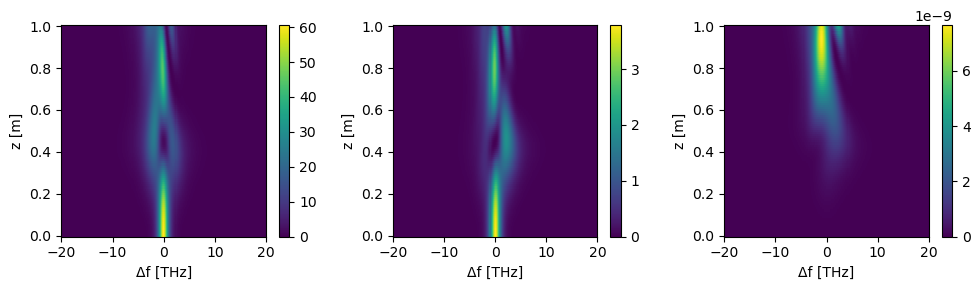

In [15]:
ZZ, FF = MultiModeNoise.meshgrid(sim["fs"] .- sim["f0"], fiber["zsave"])

fig, axs = subplots(1, 3, figsize=(10,3))
for i in 1:M
    im = axs[i].pcolormesh(ZZ, FF, abs2.(fftshift(uω_z[:,:,i], 2)), shading="nearest")
    fig.colorbar(im, ax=axs[i])
    axs[i].set_xlim(-20,20)
    axs[i].set_xlabel("Δf [THz]")
    axs[i].set_ylabel("z [m]")
end
fig.tight_layout()

In [24]:
fiber["zsave"] = nothing

In [25]:
sol_disp_mmf = MultiModeNoise.solve_disp_mmf(uω0, fiber, sim);

In [34]:
# single pixel 
XX, YY = MultiModeNoise.meshgrid(fiber["x"], fiber["x"])
ϕ_pix = fiber["ϕ"][argmin(vec((XX .- 5).^2 + (YY .- 5).^2)),:];
λωL = 2 * ((uω_z[end,:,:] * ϕ_pix) * ϕ_pix');

In [35]:
sol_adjoint_disp_mmf = MultiModeNoise.solve_adjoint_disp_mmf(λωL, sol_disp_mmf["ode_sol"], fiber, sim);

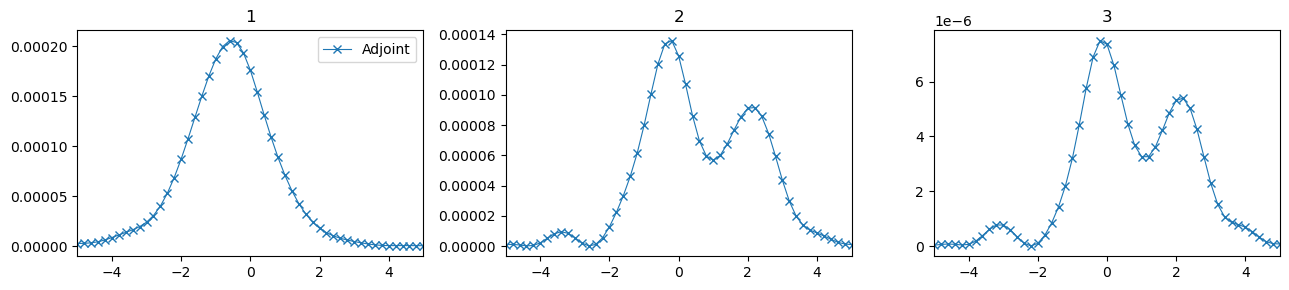

In [36]:
fig, axs = subplots(1, M, figsize=(13,3))
for i in 1:M
    axs[i].set_title(i)
    axs[i].plot((sim["fs"] .- sim["f0"]), abs2.(fftshift(sol_adjoint_disp_mmf(0)[:,i])), "x-", lw=0.8, label="Adjoint")
    axs[i].set_xlim(-5,5)
end
axs[1].legend()
fig.tight_layout()

In [37]:
# all pixels
∂Xkl∂u = zeros(ComplexF64, M, M, Nt, M)

for k in 1:M
    for l in 1:M
        λωL = 2 * uω_z[end,:,l] * diagm(ones(M))[:,k]'
        sol_adjoint_disp_mmf = MultiModeNoise.solve_adjoint_disp_mmf(λωL, sol_disp_mmf["ode_sol"], fiber, sim)
        ∂Xkl∂u[k,l,:,:] = -0.5*sqrt(sim["ε"]*Nt)*conj.(sol_adjoint_disp_mmf(0))

        print(@sprintf("\r%d/%d, %d/%d", k, M, l, M)); flush(stdout)
    end
end

3/3, 3/3

In [37]:
using Tullio

In [38]:
ϕ = fiber["ϕ"]
ε = sim["ε"]
U = u0_modes
δF_in_ω = abs2.(uω0[:,1]) ./ maximum(abs2.(uω0[:,1])) * (1e3-1)
uωf = uω_z[end,:,:];

In [39]:
@tullio X[i] := ϕ[i,k] * ϕ[i,l] * conj(uωf[ω,k]) * uωf[ω,l]
X = Nt * ε * real.(X)
var_X = MultiModeNoise.compute_noise_map(X, ∂Xkl∂u, U, ϕ, δF_in_ω);

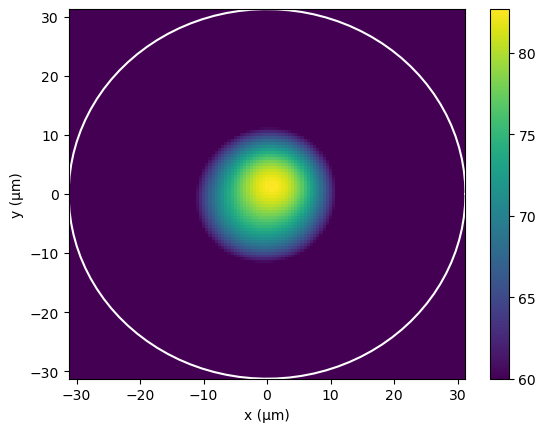

PyObject Text(24.000000000000007, 0.5, 'y (μm)')

In [40]:
MultiModeNoise.plot_fiber(fiber["x"], MultiModeNoise.lin_to_dB.(reshape(var_X, (nx, nx))), radius, radius, vmin=60)